In [1]:
import numpy as np
import pyvisa as visa
import time
from matplotlib import pyplot as plt
import pandas as pd
import os

In [2]:
rm = visa.ResourceManager()

In [3]:
rm.list_resources()

('USB0::0x0699::0x0368::C017059::INSTR', 'ASRL1::INSTR', 'ASRL10::INSTR')

In [4]:
resource_name_f=  'USB0::0x0699::0x0353::1625695::INSTR'

resource_name_o = 'USB0::0x0699::0x0368::C017062::INSTR'

osci = rm.open_resource(resource_name_o)
fungen = rm.open_resource(resource_name_f)

In [5]:
osci.query('*IDN?')

'TEKTRONIX,TBS 1052B-EDU,C017062,CF:91.1CT FV:v3.25\n'

In [6]:
fungen.query('*IDN?')

'TEKTRONIX,AFG1022,1625695,SCPI:99.0 FV:V1.2.1b\n'

In [42]:
Rs = np.array([2720.0,])
err_Rs = np.array([2720.0*0.008+20,])
err_Rs

array([41.76])

In [75]:
osci.write('DAT SOU: CH1')
xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')

yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
osci.write('DAT:SOU CH2')
yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')

osci.write('DAT:ENC RPB')
osci.write('DAT:WID 1')

osci.write("DAT:SOU CH1")
data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
osci.write("DAT:SOU CH2")
data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
tiempo = xze + np.arange(len(data1)) * xin
data1v = (data1 - yoff1) * ymu1 + yze1
data2v = (data2 - yoff2) * ymu2 + yze2

df = pd.DataFrame({'t':tiempo,'V_m':data1v,'V_e':data2v})        
df.to_csv(f'plots seke/RLC sobre/34.4.csv',index=False)

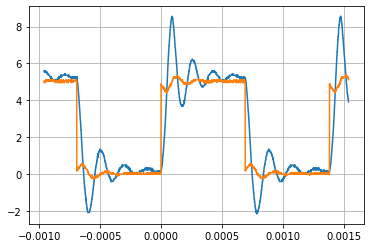

In [76]:
df = pd.read_csv('plots seke/RLC sobre/34.4.csv')
plt.plot(df.t,df.V_m)
plt.plot(df.t,df.V_e)
plt.grid()

In [9]:
def barrido_f(f_min,f_max,n,folder,scale='lin'):
    if scale == 'log':
        freqs = np.logspace(f_min,f_max,n)
    elif scale == 'lin':
        freqs = np.linspace(f_min,f_max,n)
    else:
        print('Escala inválida')
        return
    time_s = time.time()
    for freq in freqs:
        fungen.write(f'SOURCE1:FREQ {freq}')
        time.sleep(1)
        osci.write('AUTOS exec')
        time.sleep(6)
        osci.write('DAT:SOU CH1')
        xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
        
        osci.write('ACQ:STATE STOP')
        yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
        osci.write('DAT:SOU CH2')
        yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
        
        osci.write('DAT:ENC RPB')
        osci.write('DAT:WID 1')
        
        osci.write("DAT:SOU CH1")
        data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
        osci.write("DAT:SOU CH2")
        data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)
        tiempo = xze + np.arange(len(data1)) * xin
        data1v = (data1 - yoff1) * ymu1 + yze1
        data2v = (data2 - yoff2) * ymu2 + yze2

        osci.write('ACQ:STATE RUN')
        
        df = pd.DataFrame({'t':tiempo,'V_m':data1v,'V_e':data2v})
        plt.plot(df.t,df.V_m)
        plt.plot(df.t,df.V_e)
        plt.grid()
        plt.show()
        df.to_csv(f'plots seke/RLC est/{folder}/{np.round(freq,0)}.csv',index=False)

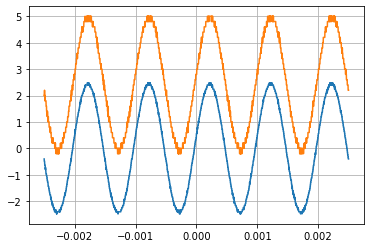

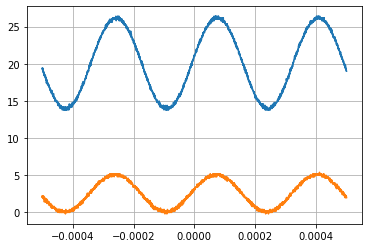

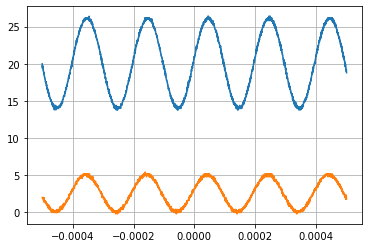

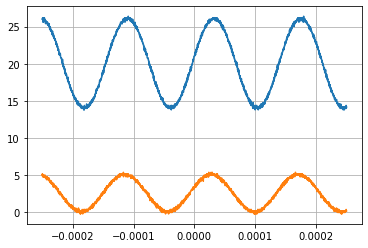

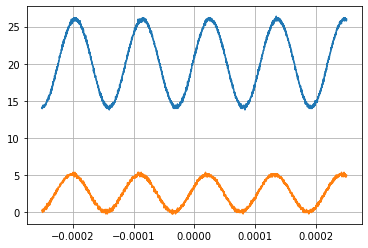

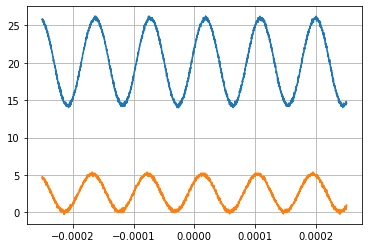

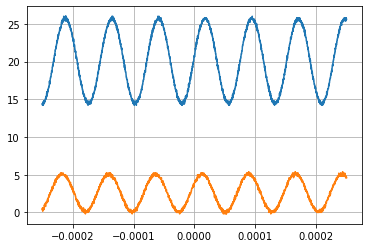

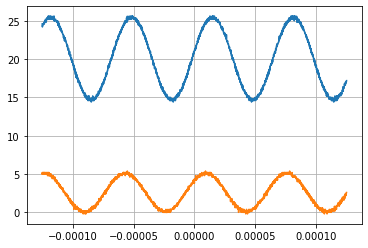

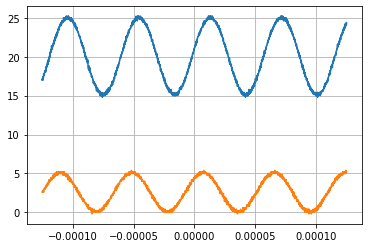

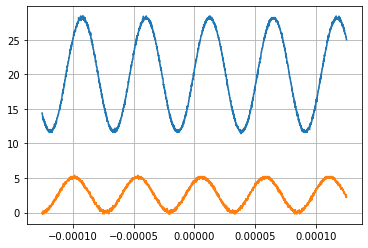

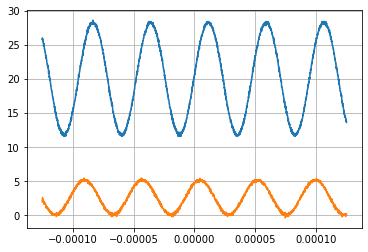

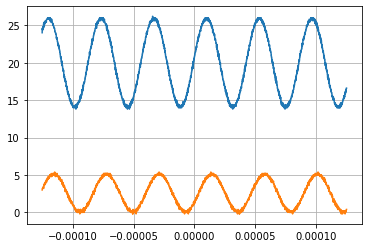

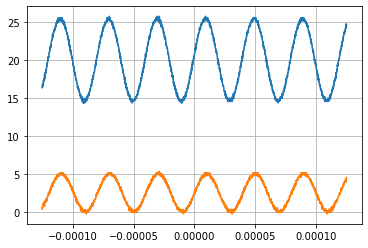

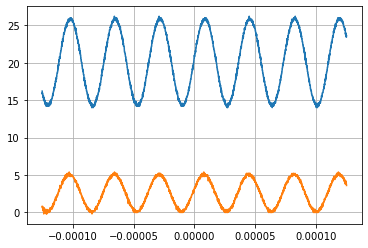

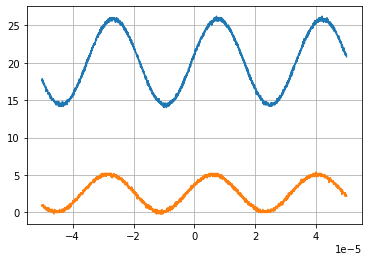

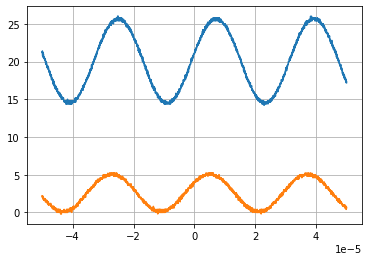

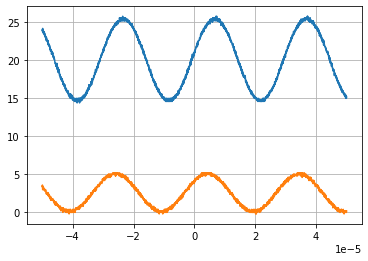

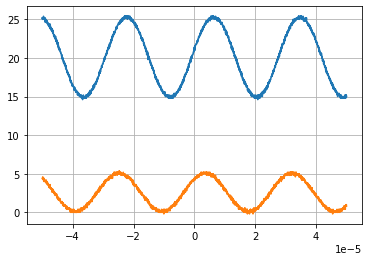

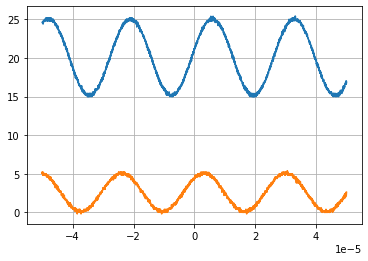

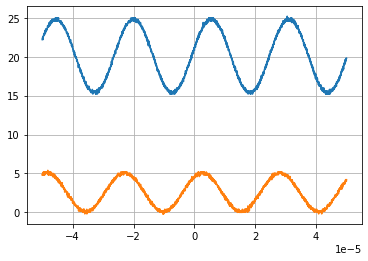

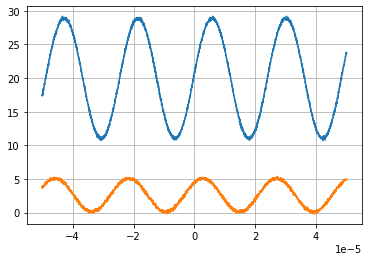

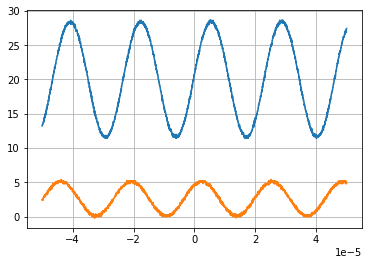

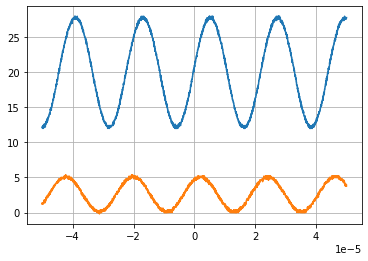

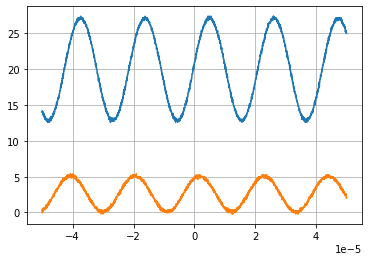

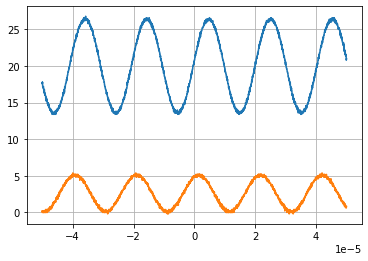

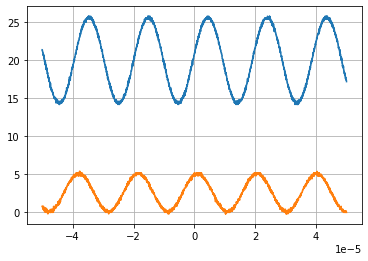

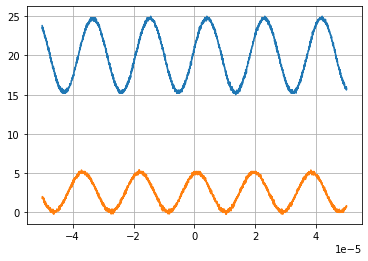

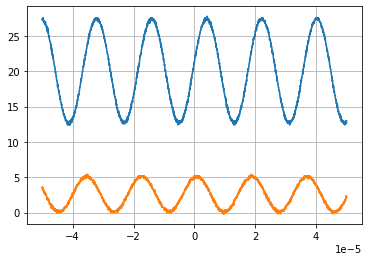

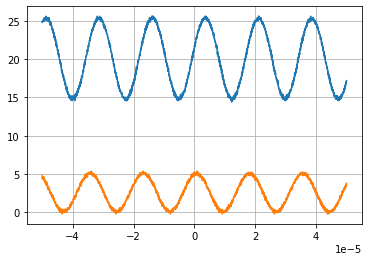

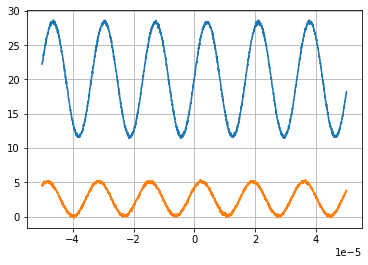

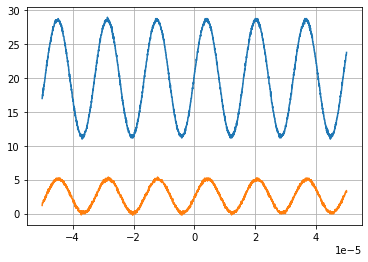

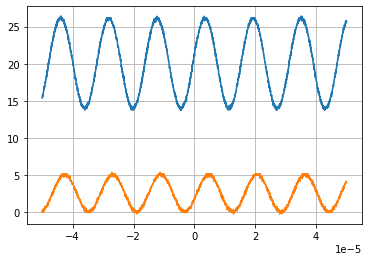

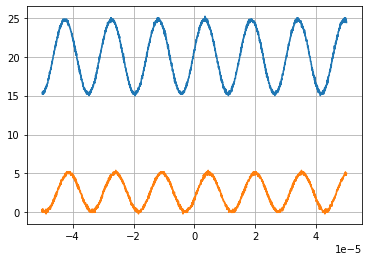

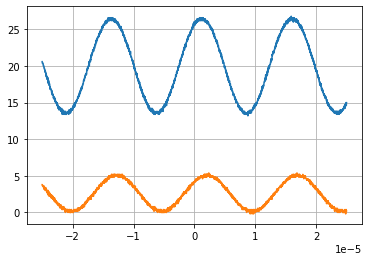

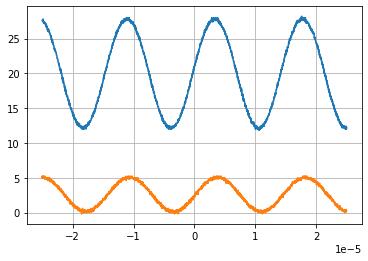

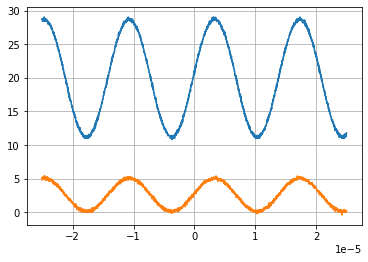

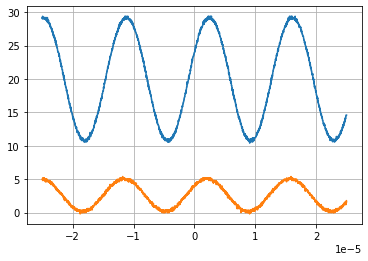

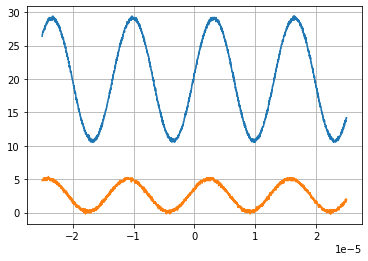

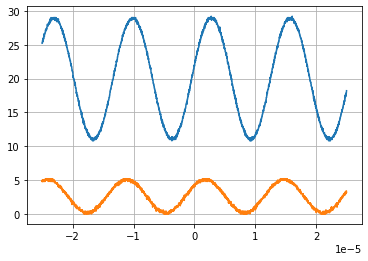

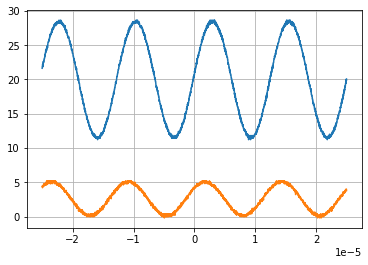

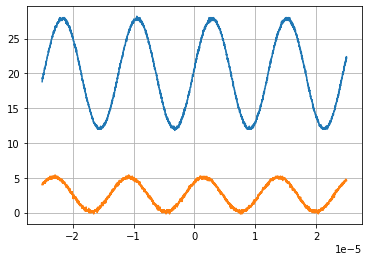

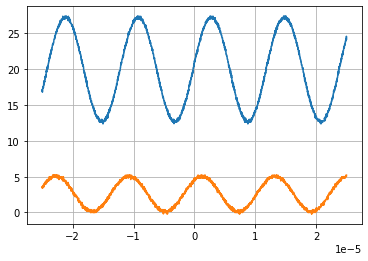

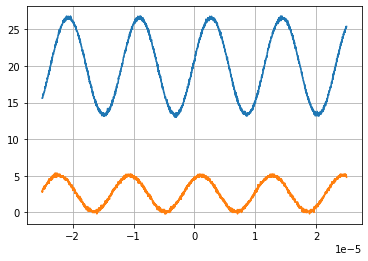

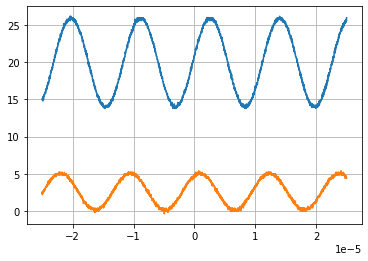

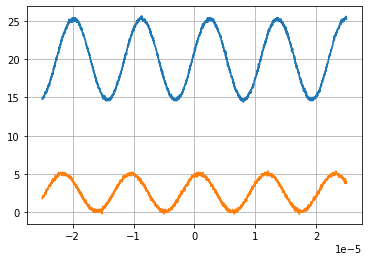

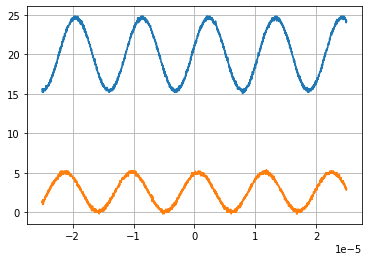

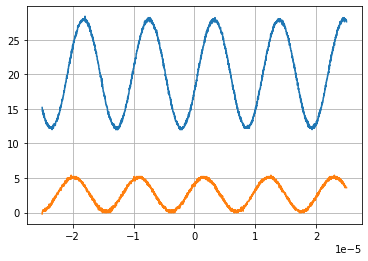

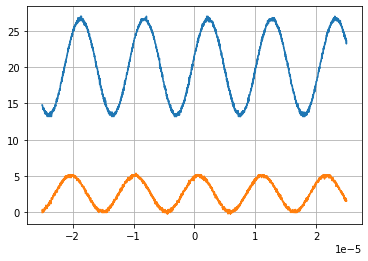

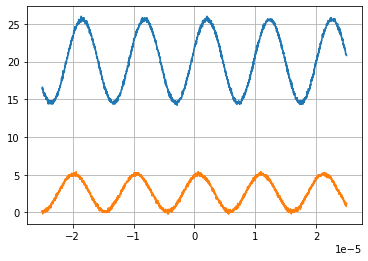

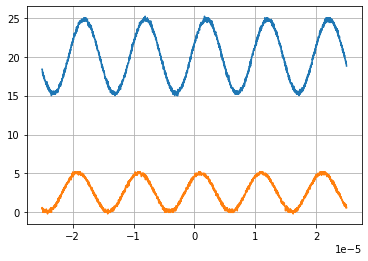

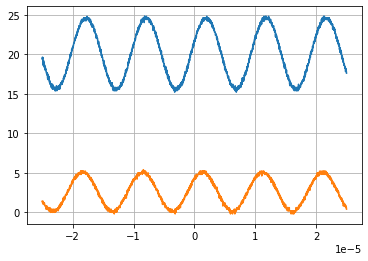

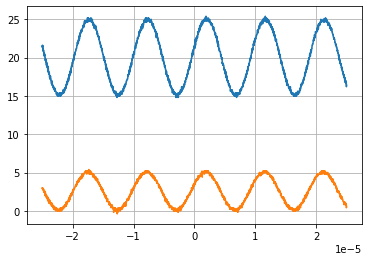

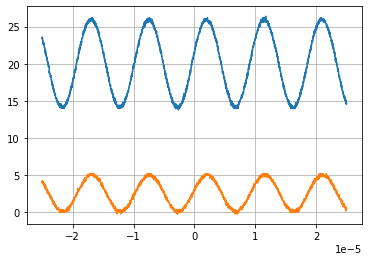

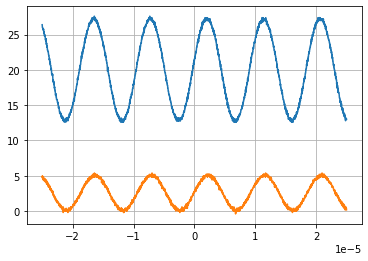

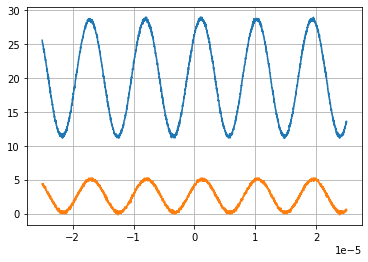

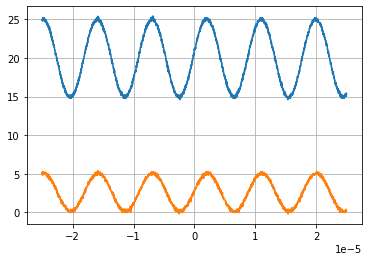

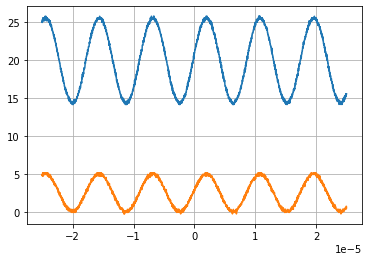

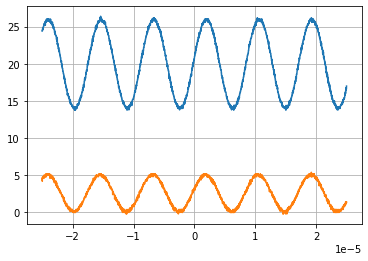

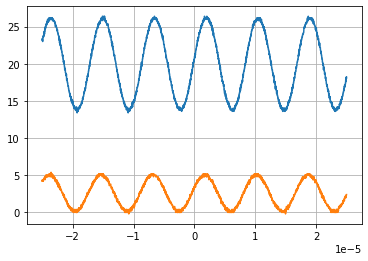

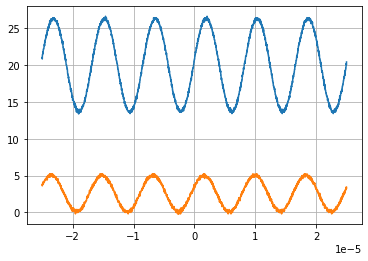

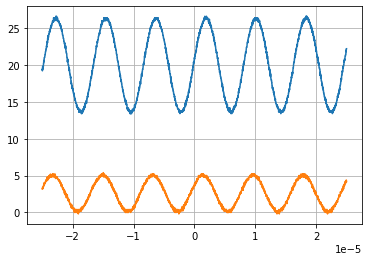

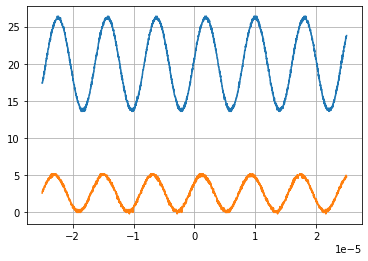

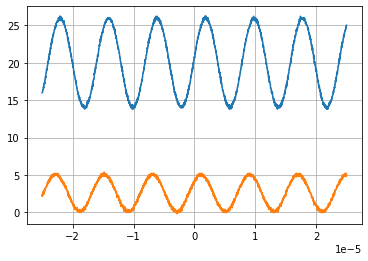

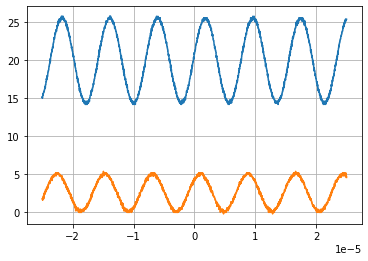

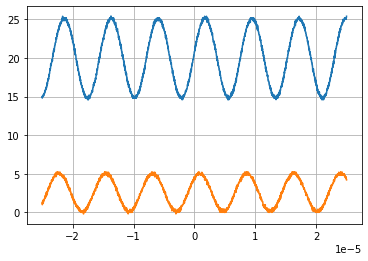

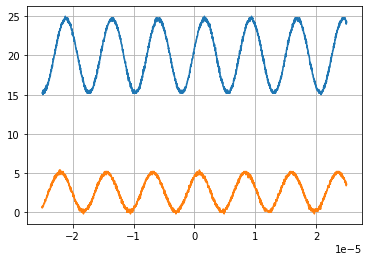

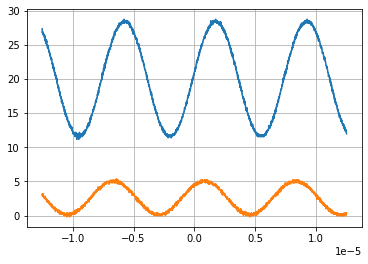

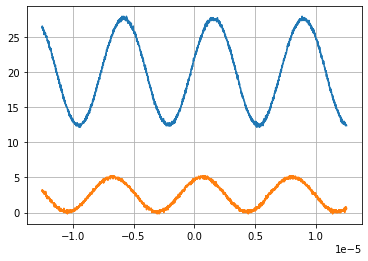

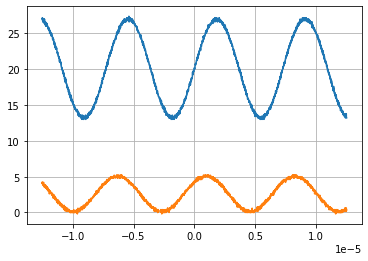

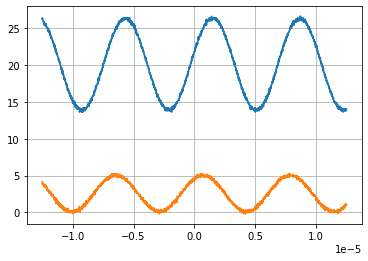

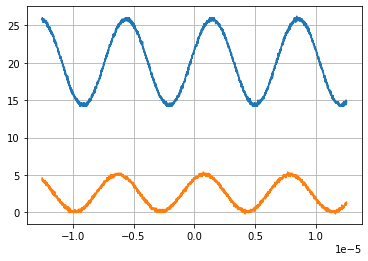

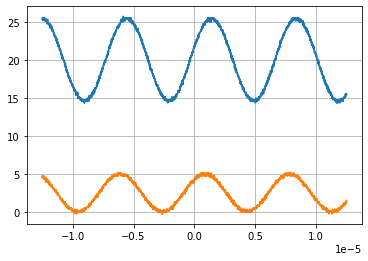

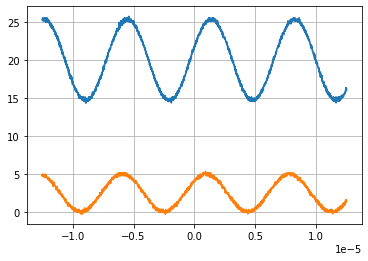

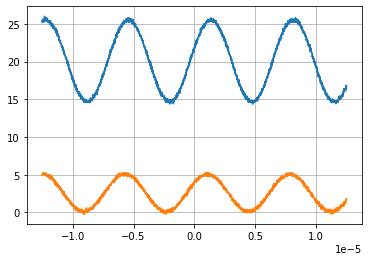

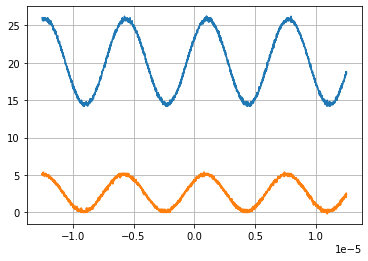

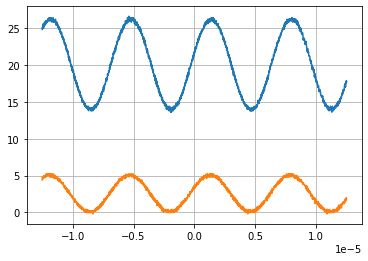

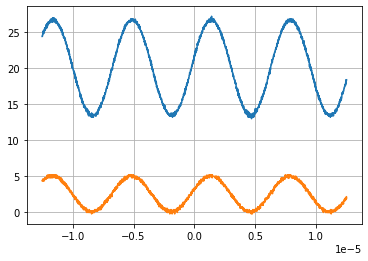

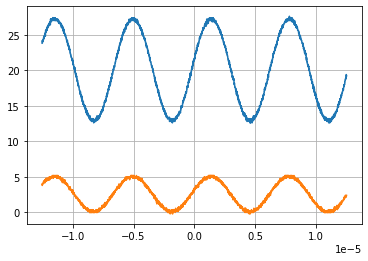

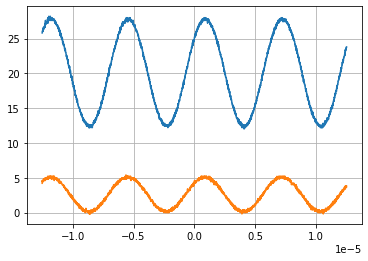

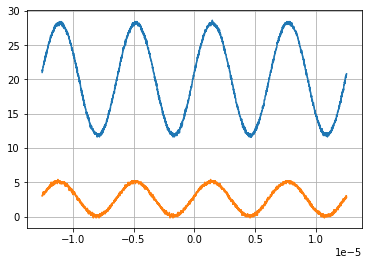

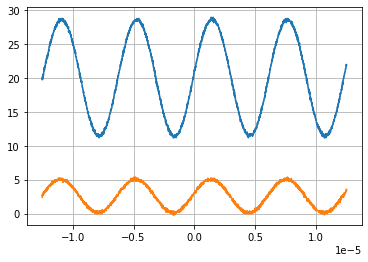

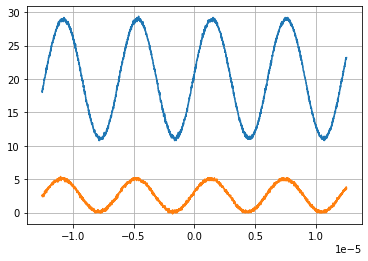

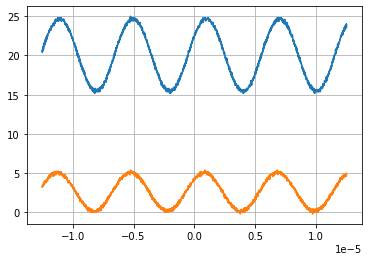

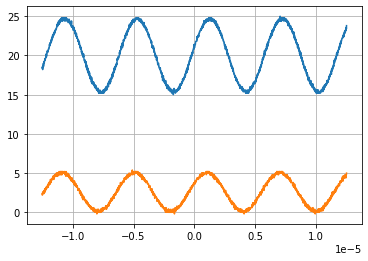

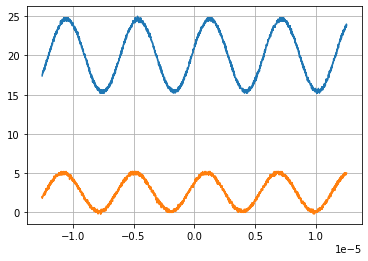

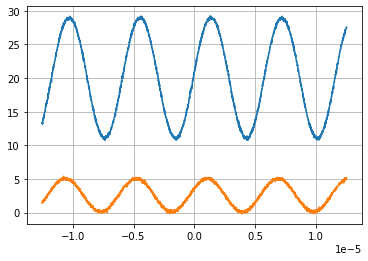

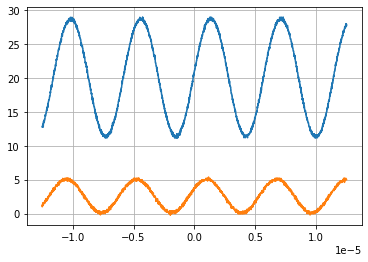

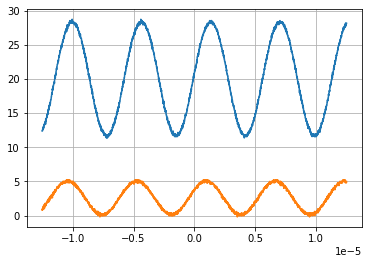

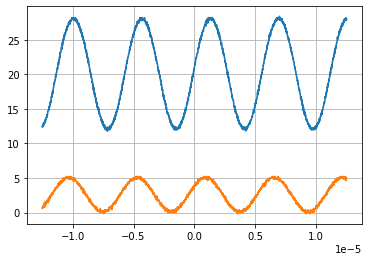

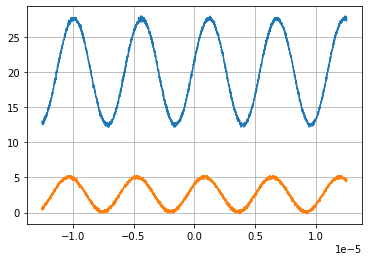

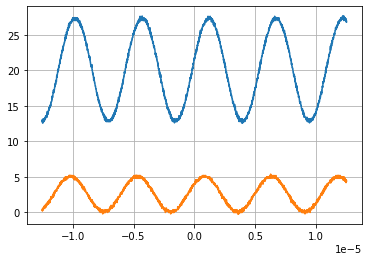

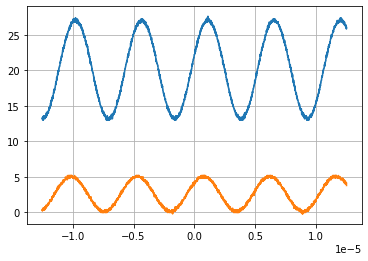

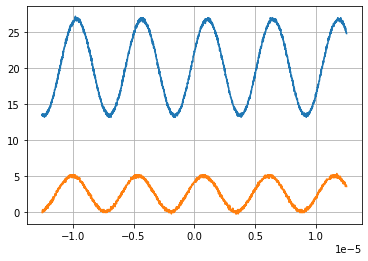

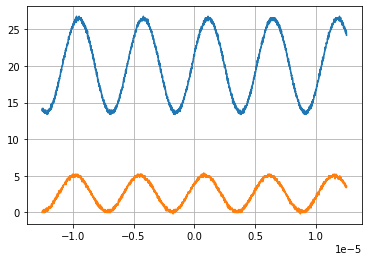

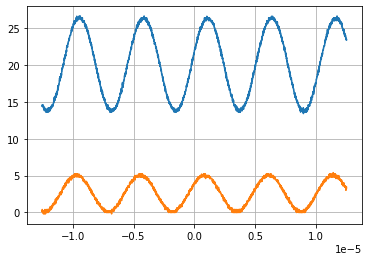

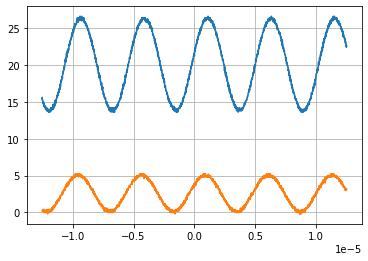

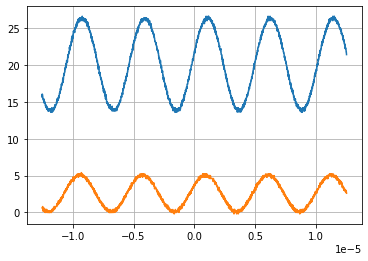

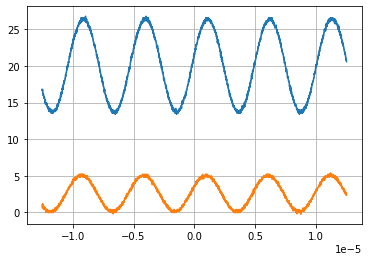

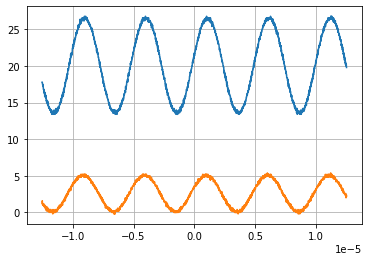

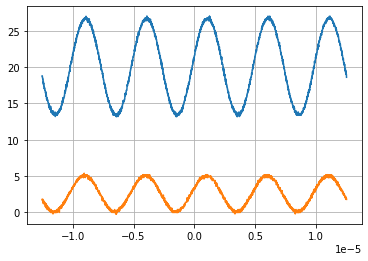

In [13]:
barrido_f(1000.0,200000.0,100,'med 2')